<span style="font-size: 14pt">MIPT, Applied ML, Autumn 2018</span>

<span style="font-size: 16pt"> HW #2: ARIMAX, Compositions, NN

<span style="color:red; font-size: 14pt;"> Дедлайн 06.10.2018 23:59 </span>

<span style="color:blue; font-size: 12pt">Alexey Romanenko </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>


<span style="color:blue; font-size: 12pt">Radoslav Neychev </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">neychev@phystech.edu</span>

**Дополнительный материал для выполнения дз**:
- Лукашин Ю.П. Адаптивные методы краткосрочного прогнозирования временных рядов. Финансы и статистика. 2003, главы 1,4,5,7.
- Магнус Я.Р., Катышев П.К., Пересецкий А.А. Эконометрика. Начальный курс., глава 11
- 

**Оформление дз**: 
- Выполненное задание требуется отправлять через <a href='https://goo.gl/forms/XPSIbwp7wPxB4SsI3'>форму </a>
    - <span style="color:red; font-size: 20pt">ВНИМАНИЕ: для отправки задания потребуется почта в домене gmail.com или phystech.edu</span> 
- Выполненное дз прикрепляйте в формате файла ``<фамилия>_<группа>_task<номер>.ipynb``, например: ``ivanov_594_task1.ipynb`` 

**Вопросы**:
- Вопросы присылайте на почту ml.course.mipt@gmail.com
- Укажите тему письма в следующем формате ``ML2018_fall_Question_<Тема вопроса>``

--------
- **PS1**: Будьте внимательны при заполнении формы, когда отправляете ДЗ 


<h1 align="center">Теоретическая часть (20%)</h1> 

При ответе на вопросы своими словами (загугленный материал надо пересказать), ответ обоснуйте (напишите и ОБЪЯСНИТЕ формулки если потребуется), если не выходит, то вернитесь к лекции дополнительным материалам.

---

**Вопрос 1 (4%)**  Напишите уравнение временного ряда (в виде $y_t=f\left(y_{t-1}, \dots, y_1,~\varepsilon_{t},\dots, \varepsilon_{1}\right)$) которая соответствует модели:
   * 1) ARIMA $(p=1,d=k,q=0)$,
     - <Ответ>
     <img src="1.jpg">
   * 2) ARIMA $(p=1,d=k+1,d=0)(P=0, D=1, Q=1)_s$,
     - <Ответ>
     <img src="2.jpg">
--- 
**Вопрос 2 (4%)**   
   * 1) Опишите ситуацию (аргументированно), в котором композиция Adaptive Composition будет прогнозировать хуже, чем лучший из базовых алгоритмов.
    - <Ответ>
   * 2) Опишите ситуацию (аргументированно), в котором композиция Adaptive Selection будет прогнозировать хуже, чем лучший из базовых алгоритмов.
    - <Ответ>

---

**Вопрос 3 (6%)** Покажите, что ARIMA$(p=1,d=2, q=2)$ эквивалентна модели ЭС с линейным затухающим трендом (damped-trend linear exponential smoothing ) при условиях:
		$$(1-\phi B)(1-B)Y_t = (1-\theta_1 B-\theta_2 B^2)\epsilon_t$$
		$$\theta_1 = 1+\phi-\alpha-\alpha\beta\phi, \text{ } \theta_2 = (\alpha-1)\phi$$
        $\phi$~--- coefficient of damped trend.

---        

**Вопрос 4 (6%)**: Покажите, что для модели  
    $$AR(p)\colon \;\;\; y_t = \phi_1 y_{t-1} + \phi_2 y_{t-2} + \dots + \phi_p y_{t-p} + \varepsilon_t,$$  
    где $y_t$ стационарный процесс с нулевым средним,$~~$
    $\phi_1,\dots,\phi_p$ - константы ($\phi_p \neq 0$), $~~$
    $\varepsilon_t$ несмещённый гауссовский шум с дисперсией $\sigma_\varepsilon^2 $
выполнено:

  * 1) частный коэффициент автокорреляции
   $$\phi_{\tau\tau} = \mathsf{E}[y_t-\hat y_t, y_{t+\tau} - \hat y_{t+\tau}]= \begin{cases}0 &, \tau>p; \\ f(\tau,p)>0 &, 0\leq\tau\leq p. \end{cases}$$
	
  где $\hat y_t$ - прогноз $y_t$ согласно следующей регрессионной модели $$y_t = \sum_{j=1}^{\tau-1}\beta_j y_{t+j}$$
    $\hat y_{t+\tau}$ - прогноз $y_{t\tau}$ согласно следующей регрессионной модели $$y_{t+\tau} = \sum_{j=1}^{\tau-1}\gamma_j y_{t+j}.$$

<Ответ>

In [1]:
import numpy as np
from datetime import datetime, timedelta
import pylab
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import math
import pandas.tseries.offsets as ofs
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa import stattools

import warnings as w
#import plotly.plotly as py
from IPython.display import Image

from utils import qualityMACAPE, qualityRMSE

%matplotlib inline

C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<h1 align="center">Практическая часть I (30%)</h1>
Требуется проанализировать временной ряд и спрогнозировать его моделю ARIMA. 
Каждый студент прогнозирует свой собсвтенный временной ряд, соответствующий ВР нужно смотреть на листе HW2_TS <a href="https://docs.google.com/spreadsheets/d/188zdwJ1onHseMCvtRK3_uh6WW8prHssoiZ9l-_Mfk0M/edit#gid=1703509799">здесь</a>. 

(Каждый из нижеследующих пунктов задания оценивается в 3% от общего веса задания).

* 0) read data for TS under consideration and use the first 80% of all length of the TS as train TS.  

In [2]:
# Put your code here
ts_wage = pd.read_csv("monthly-sutter-county-workforce-.csv", sep=',', index_col=0)
ts_wage= ts_wage.rename(columns={'Month': 'Month', 'Monthly Sutter county workforce, Jan.1946 ? Dec.1966 priesema (1979)': 'MonthlySutter'})
ts_wage.index.names=['Month']
ts_wage = ts_wage.sort_index() # sort index
ts_wage.head()

,MonthlySutter
Month,
1946-01,890
1946-02,992
1946-03,979
1946-04,959
1946-05,1110


In [3]:
len_80_per = int(len(ts_wage) * 0.8)

In [4]:
ts_wage_train = ts_wage[0:len_80_per]
ts_wage_test = ts_wage[len_80_per:252] #в последней строке нет нужных данных

In [5]:
ts_wage_test.tail()

,MonthlySutter
Month,
1966-08,6905
1966-09,5504
1966-10,5457
1966-11,5198
1966-12,4890


In [6]:
ts_wage_train.head()

,MonthlySutter
Month,
1946-01,890
1946-02,992
1946-03,979
1946-04,959
1946-05,1110


* 1) plot the graph of the train TS, preprocess data (delete tail, make calendar transformation if needed)

In [7]:
ts_wage_train = ts_wage_train.astype(float)

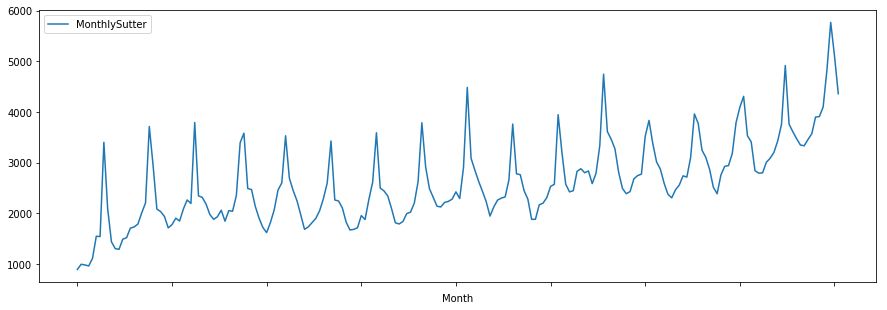

In [8]:
# Put your code here
ts_wage_train.plot(figsize=(15,5))

* 2) stabilize dispersion of the train TS through box-cox transformation if needed.

Заметим, что в этом ряде сильно выражена годовая сезонность, поэтому он стационарным не является.

Для того, чтобы превратить его в стационарный попробуем стабилизировать дисперсию.

In [9]:
from copy import deepcopy
ts_wage_boxcox = deepcopy(ts_wage_train)
# find optimal lambda 
print('optimal lambda:', stats.boxcox(ts_wage_train)[1][0])

optimal lambda: 0.24640496223812536


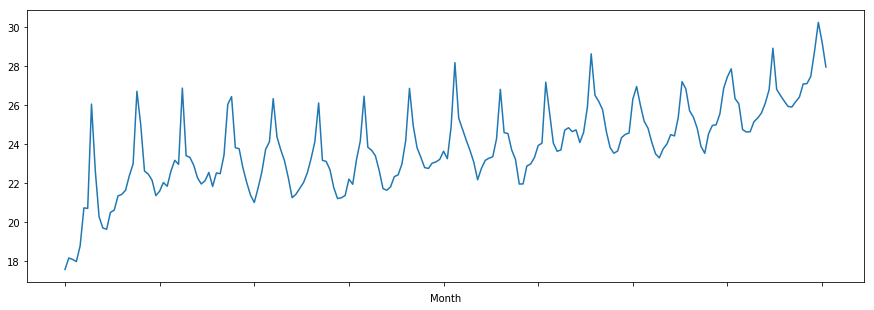

In [10]:
ts_wage_boxcox['wage_boxcox'] = stats.boxcox(ts_wage_train)[0]
ts_wage_boxcox['wage_boxcox'].plot(figsize=(15,5))

* 3) if the transformed train TS is non-stationary make it stationary (remember the power of differencing $d$).

Ряд все еще не стационарен. Поэтому продиффиренцируем его.

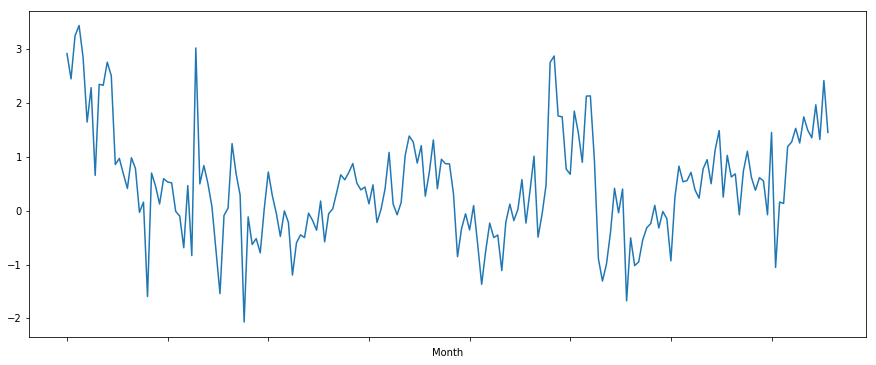

In [11]:
# Put your code here
# seasonal differencing
p = 12
sdiff_ts_wage_boxcox = (ts_wage_boxcox['wage_boxcox'] - ts_wage_boxcox['wage_boxcox'].shift(p))[p:]
sdiff_ts_wage_boxcox.plot(figsize=(15,6))


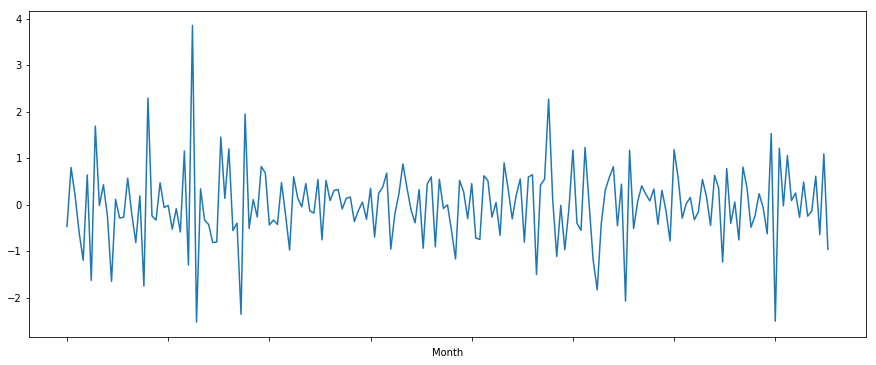

In [12]:
diff_sdiff_ts_wage_boxcox = (sdiff_ts_wage_boxcox  - sdiff_ts_wage_boxcox .shift(1))[1:]
diff_sdiff_ts_wage_boxcox.plot(figsize=(15,6))

Ура-ура, ряд стал стационарным.

* 4) plot ACF/PACF for  the transformed train TS in order to understand whether $AR(p)/MA(q)$ may be used.

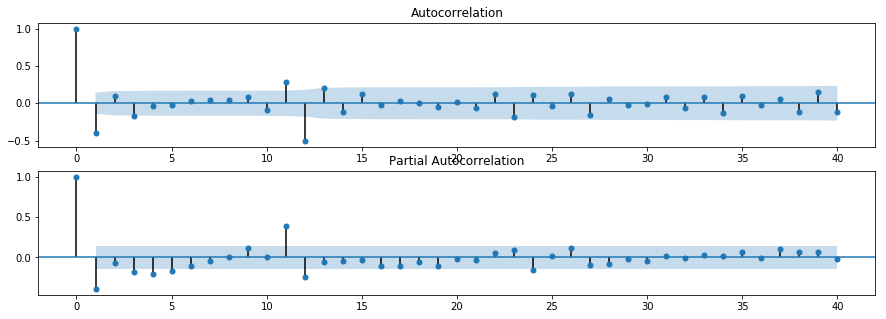

In [13]:
# Put your code here
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff_sdiff_ts_wage_boxcox.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff_sdiff_ts_wage_boxcox.values.squeeze(), lags=40, ax=ax2)

* 5) select set of candidate parameters for ARMA (for the train TS)

По графикам видим, что кандидатами в q (ACF) являются 1, 3, 11

    в p (PACF): 1, 4, 11 (3, 5)

* 6) train candidate ARIMA models (use $d$ from step 3), $p$, $q$ from step 5)), compare their AIC, choose the best model.

Мы сделали наш ряд стационарным => d=1

In [14]:
# Put your code here
## Choosing best model accoridng to AIC criterion p, d, q
arima_mod_1_1_1 = sm.tsa.ARIMA(sdiff_ts_wage_boxcox, (1,1,1)).fit()
print(arima_mod_1_1_1.params)
print(arima_mod_1_1_1.aic, arima_mod_1_1_1.bic, arima_mod_1_1_1.hqic)

C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


const                 -0.005953
ar.L1.D.wage_boxcox    0.234317
ma.L1.D.wage_boxcox   -0.722907
dtype: float64
430.6975138626425 443.6645019228811 435.9507526033475


In [15]:
arima_mod_1_1_3 = sm.tsa.ARIMA(sdiff_ts_wage_boxcox, (1,1,3)).fit()
print(arima_mod_1_1_3.params)
print(arima_mod_1_1_3.aic, arima_mod_1_1_3.bic, arima_mod_1_1_3.hqic)

C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


const                 -0.005599
ar.L1.D.wage_boxcox   -0.013761
ma.L1.D.wage_boxcox   -0.483935
ma.L2.D.wage_boxcox    0.033433
ma.L3.D.wage_boxcox   -0.202206
dtype: float64
428.34735998644686 447.7978420768047 436.22721809750436


In [16]:
arima_mod_1_1_11 = sm.tsa.ARIMA(sdiff_ts_wage_boxcox, (1,1,11)).fit()
print(arima_mod_1_1_11.params)
print(arima_mod_1_1_11.aic, arima_mod_1_1_11.bic, arima_mod_1_1_11.hqic)

C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


const                  -0.006529
ar.L1.D.wage_boxcox    -0.775787
ma.L1.D.wage_boxcox     0.351749
ma.L2.D.wage_boxcox    -0.566738
ma.L3.D.wage_boxcox    -0.431270
ma.L4.D.wage_boxcox    -0.092818
ma.L5.D.wage_boxcox     0.239313
ma.L6.D.wage_boxcox     0.410267
ma.L7.D.wage_boxcox     0.297363
ma.L8.D.wage_boxcox     0.043478
ma.L9.D.wage_boxcox    -0.264310
ma.L10.D.wage_boxcox   -0.392642
ma.L11.D.wage_boxcox    0.131148
dtype: float64
408.1524722151831 453.5369304260181 426.5388078076505


C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [200]:
arima_mod_3_1_1 = sm.tsa.ARIMA(sdiff_ts_wage_boxcox, (3,1,1)).fit()
print(arima_mod_3_1_1.params)
print(arima_mod_3_1_1.aic, arima_mod_3_1_1.bic, arima_mod_3_1_1.hqic)

C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


const                 -0.005815
ar.L1.D.wage_boxcox    0.175341
ar.L2.D.wage_boxcox    0.100454
ar.L3.D.wage_boxcox   -0.192806
ma.L1.D.wage_boxcox   -0.667561
dtype: float64
427.0757939983633 446.52627608872115 434.9556521094208


C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


In [201]:
arima_mod_3_1_3 = sm.tsa.ARIMA(sdiff_ts_wage_boxcox, (3,1,3)).fit()
print(arima_mod_3_1_3.params)
print(arima_mod_3_1_3.aic, arima_mod_3_1_3.bic, arima_mod_3_1_3.hqic)

C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


const                 -0.006151
ar.L1.D.wage_boxcox   -0.705033
ar.L2.D.wage_boxcox   -0.646027
ar.L3.D.wage_boxcox    0.187582
ma.L1.D.wage_boxcox    0.244996
ma.L2.D.wage_boxcox    0.291071
ma.L3.D.wage_boxcox   -0.728346
dtype: float64
428.30337499340817 454.2373511138853 438.8098524748181


C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [202]:
arima_mod_3_1_11 = sm.tsa.ARIMA(sdiff_ts_wage_boxcox, (3,1,11)).fit()
print(arima_mod_3_1_11.params)
print(arima_mod_3_1_11.aic, arima_mod_3_1_11.bic, arima_mod_3_1_11.hqic)

C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


const                  -0.003580
ar.L1.D.wage_boxcox    -1.385791
ar.L2.D.wage_boxcox    -1.119409
ar.L3.D.wage_boxcox    -0.493140
ma.L1.D.wage_boxcox     1.068090
ma.L2.D.wage_boxcox     0.734979
ma.L3.D.wage_boxcox     0.046546
ma.L4.D.wage_boxcox    -0.355887
ma.L5.D.wage_boxcox    -0.078450
ma.L6.D.wage_boxcox     0.337803
ma.L7.D.wage_boxcox     0.580903
ma.L8.D.wage_boxcox     0.491680
ma.L9.D.wage_boxcox     0.279550
ma.L10.D.wage_boxcox    0.276334
ma.L11.D.wage_boxcox    0.501928
dtype: float64
403.652961403214 455.52091364416833 424.66591636603397


C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [203]:
arima_mod_4_1_1 = sm.tsa.ARIMA(sdiff_ts_wage_boxcox, (4,1,1)).fit()
print(arima_mod_4_1_1.params)
print(arima_mod_4_1_1.aic, arima_mod_4_1_1.bic, arima_mod_4_1_1.hqic)

C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


const                 -0.005856
ar.L1.D.wage_boxcox    0.024370
ar.L2.D.wage_boxcox    0.049892
ar.L3.D.wage_boxcox   -0.207558
ar.L4.D.wage_boxcox   -0.144788
ma.L1.D.wage_boxcox   -0.534074
dtype: float64
426.4443875119905 449.136616617408 435.63755530822425


C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


In [204]:
arima_mod_4_1_3 = sm.tsa.ARIMA(sdiff_ts_wage_boxcox, (4,1,3)).fit()
print(arima_mod_4_1_3.params)
print(arima_mod_4_1_3.aic, arima_mod_4_1_3.bic, arima_mod_4_1_3.hqic)

C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


const                 -0.006784
ar.L1.D.wage_boxcox    0.101579
ar.L2.D.wage_boxcox    0.738113
ar.L3.D.wage_boxcox   -0.578119
ar.L4.D.wage_boxcox   -0.404718
ma.L1.D.wage_boxcox   -0.720960
ma.L2.D.wage_boxcox   -0.679621
ma.L3.D.wage_boxcox    0.975958
dtype: float64
404.614469567181 433.7901927027178 416.4342567337672


C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [205]:
arima_mod_4_1_11 = sm.tsa.ARIMA(sdiff_ts_wage_boxcox, (4,1,11)).fit()
print(arima_mod_4_1_11.params)
print(arima_mod_4_1_11.aic, arima_mod_4_1_11.bic, arima_mod_4_1_11.hqic)

C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


const                  -0.004540
ar.L1.D.wage_boxcox    -1.652069
ar.L2.D.wage_boxcox    -1.596329
ar.L3.D.wage_boxcox    -1.084476
ar.L4.D.wage_boxcox    -0.381077
ma.L1.D.wage_boxcox     1.281499
ma.L2.D.wage_boxcox     1.026048
ma.L3.D.wage_boxcox     0.375934
ma.L4.D.wage_boxcox    -0.299589
ma.L5.D.wage_boxcox    -0.329918
ma.L6.D.wage_boxcox     0.183974
ma.L7.D.wage_boxcox     0.571715
ma.L8.D.wage_boxcox     0.632625
ma.L9.D.wage_boxcox     0.463996
ma.L10.D.wage_boxcox    0.329126
ma.L11.D.wage_boxcox    0.408285
dtype: float64
395.39100063698737 450.5006998930013 417.71726528498357


C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [206]:
arima_mod_5_1_1 = sm.tsa.ARIMA(sdiff_ts_wage_boxcox, (5,1,1)).fit()
print(arima_mod_5_1_1.params)
print(arima_mod_5_1_1.aic, arima_mod_5_1_1.bic, arima_mod_5_1_1.hqic)

C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


const                 -0.005788
ar.L1.D.wage_boxcox   -0.126514
ar.L2.D.wage_boxcox   -0.031135
ar.L3.D.wage_boxcox   -0.230512
ar.L4.D.wage_boxcox   -0.189346
ar.L5.D.wage_boxcox   -0.103810
ma.L1.D.wage_boxcox   -0.391942
dtype: float64
427.3015839521202 453.23556007259737 437.80806143353016


In [207]:
arima_mod_5_1_3 = sm.tsa.ARIMA(sdiff_ts_wage_boxcox, (5,1,3)).fit()
print(arima_mod_5_1_3.params)
print(arima_mod_5_1_3.aic, arima_mod_5_1_3.bic, arima_mod_5_1_3.hqic)

C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


const                 -0.007360
ar.L1.D.wage_boxcox    0.110324
ar.L2.D.wage_boxcox    0.775848
ar.L3.D.wage_boxcox   -0.617620
ar.L4.D.wage_boxcox   -0.404385
ar.L5.D.wage_boxcox    0.041533
ma.L1.D.wage_boxcox   -0.709588
ma.L2.D.wage_boxcox   -0.709802
ma.L3.D.wage_boxcox    0.999786
dtype: float64
406.8370723020955 439.25454245269196 419.97016915385797


C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [208]:
arima_mod_5_1_11 = sm.tsa.ARIMA(sdiff_ts_wage_boxcox, (5,1,11)).fit()
print(arima_mod_5_1_11.params)
print(arima_mod_5_1_11.aic, arima_mod_5_1_11.bic, arima_mod_5_1_11.hqic)

C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


const                  -0.004813
ar.L1.D.wage_boxcox    -0.981552
ar.L2.D.wage_boxcox    -0.393597
ar.L3.D.wage_boxcox    -0.601313
ar.L4.D.wage_boxcox    -1.009619
ar.L5.D.wage_boxcox    -0.570196
ma.L1.D.wage_boxcox     0.633455
ma.L2.D.wage_boxcox    -0.028584
ma.L3.D.wage_boxcox     0.229188
ma.L4.D.wage_boxcox     0.687694
ma.L5.D.wage_boxcox     0.251428
ma.L6.D.wage_boxcox    -0.146339
ma.L7.D.wage_boxcox     0.088582
ma.L8.D.wage_boxcox     0.337164
ma.L9.D.wage_boxcox     0.362827
ma.L10.D.wage_boxcox    0.213839
ma.L11.D.wage_boxcox    0.498293
dtype: float64
408.10583314293217 466.4572794140057 431.7454074761046


C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [209]:
arima_mod_11_1_1 = sm.tsa.ARIMA(sdiff_ts_wage_boxcox, (11,1,1)).fit()
print(arima_mod_11_1_1.params)
print(arima_mod_11_1_1.aic, arima_mod_11_1_1.bic, arima_mod_11_1_1.hqic)

C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


const                  -0.004683
ar.L1.D.wage_boxcox    -0.869917
ar.L2.D.wage_boxcox    -0.471726
ar.L3.D.wage_boxcox    -0.429657
ar.L4.D.wage_boxcox    -0.389719
ar.L5.D.wage_boxcox    -0.248113
ar.L6.D.wage_boxcox    -0.072911
ar.L7.D.wage_boxcox     0.080928
ar.L8.D.wage_boxcox     0.211206
ar.L9.D.wage_boxcox     0.265447
ar.L10.D.wage_boxcox    0.276338
ar.L11.D.wage_boxcox    0.431857
ma.L1.D.wage_boxcox     0.430858
dtype: float64
391.16445319092713 436.5489114017621 409.5507887833946


In [210]:
arima_mod_11_1_3 = sm.tsa.ARIMA(sdiff_ts_wage_boxcox, (11,1,3)).fit()
print(arima_mod_11_1_3.params)
print(arima_mod_11_1_3.aic, arima_mod_11_1_3.bic, arima_mod_11_1_3.hqic)

C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


const                  -0.005216
ar.L1.D.wage_boxcox    -0.954478
ar.L2.D.wage_boxcox    -0.775698
ar.L3.D.wage_boxcox    -0.733302
ar.L4.D.wage_boxcox    -0.557288
ar.L5.D.wage_boxcox    -0.394789
ar.L6.D.wage_boxcox    -0.216898
ar.L7.D.wage_boxcox    -0.027601
ar.L8.D.wage_boxcox     0.149100
ar.L9.D.wage_boxcox     0.248941
ar.L10.D.wage_boxcox    0.298908
ar.L11.D.wage_boxcox    0.459766
ma.L1.D.wage_boxcox     0.522484
ma.L2.D.wage_boxcox     0.319128
ma.L3.D.wage_boxcox     0.194044
dtype: float64
391.99298414156897 443.8609363825233 413.0059391043889


In [211]:
arima_mod_11_1_11 = sm.tsa.ARIMA(sdiff_ts_wage_boxcox, (11,1,11)).fit()
print(arima_mod_11_1_11.params)
print(arima_mod_11_1_11.aic, arima_mod_11_1_11.bic, arima_mod_11_1_11.hqic)

C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:584: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:585: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:585: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:586: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\

LinAlgError: SVD did not converge

Минимум значения критерия aic, равный 391.16445319092713, наблюдается при p = 11 и q = 1. Это и есть лучшие параметры.

* 7) check test for unbiasedness, stationarity and non-autocorrelation of the residuals of the best ARIMA model; if the tests fail you need to review your choice.

In [212]:
#Unbiasedness test
# Darbin_Watson statistic
sm.stats.durbin_watson(arima_mod_11_1_1.resid.values)

C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


1.9629692816608466

In [213]:
stat = stats.wilcoxon(arima_mod_11_1_1.resid.values)
print('Statistic: %f\npvalue: %.2f' %(stat[0], stat[1]))

Statistic: 8514.000000
pvalue: 0.54


Тест показывает, что данные несмещены.

In [214]:
#stationary test
# Kwiatkowski–Phillips–Schmidt–Shin
kpss_stat= stattools.kpss(arima_mod_11_1_1.resid.values)
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.168109, 
pvalue: 0.10 
maximal Lag: 15 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


Тест подтверждает, что ряд стационарен.

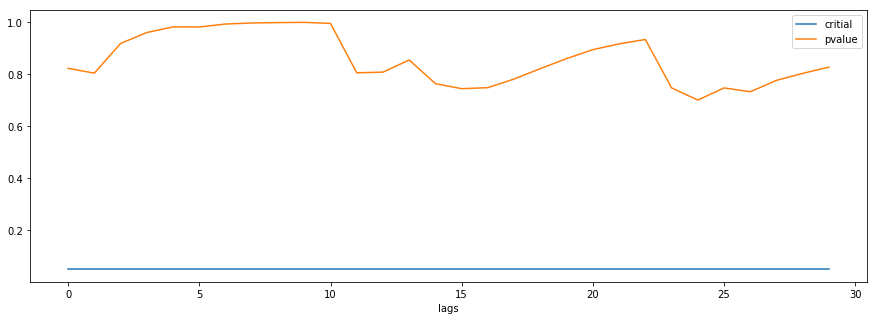

In [215]:
#autocorrelation test
# Ljung-Box test 
pd.DataFrame({'lags':range(30), 
              'pvalue':sm.stats.diagnostic.acorr_ljungbox(arima_mod_11_1_1.resid.values, lags=30)[1], 
              'critial':np.array([0.05]*30)}).set_index('lags').plot(figsize=(15,5))
# plt.plot(sm.stats.diagnostic.acorr_ljungbox(arma_mod00.resid.values, lags=30)[1],'b')

Тест подтверждает, что данные нескоррелированы.

* 8) build forecast for the initial TS (you need to transform it like in step 2)

In [278]:
# Put your code here
ts_wage = ts_wage[:-1].astype(float)
ts_wage_boxcox_all = deepcopy(ts_wage)
# find optimal lambda 
print('optimal lambda:', stats.boxcox(ts_wage)[1][0])

optimal lambda: 0.13575282742879685


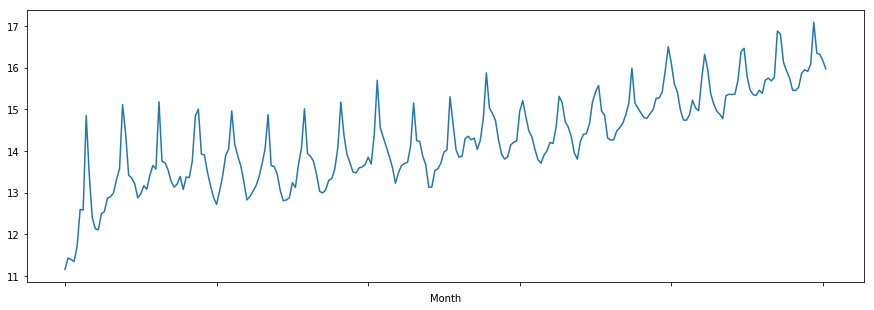

In [279]:
ts_wage_boxcox_all['wage_boxcox_all'] = stats.boxcox(ts_wage)[0]
ts_wage_boxcox_all['wage_boxcox_all'].plot(figsize=(15,5))

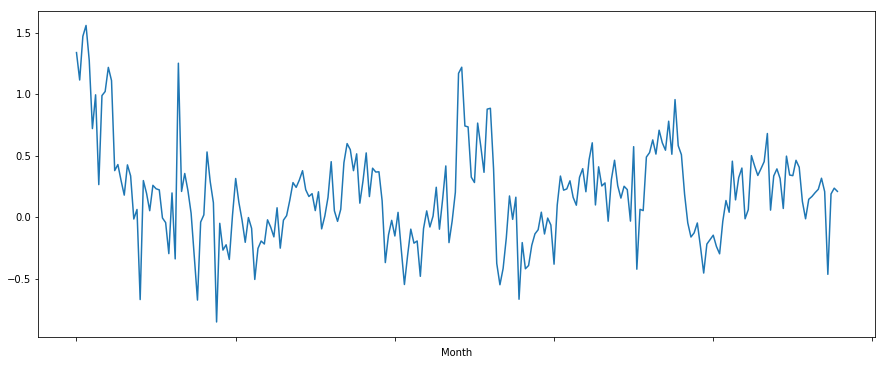

In [280]:
p = 12
sdiff_ts_wage_boxcox_all = (ts_wage_boxcox_all['wage_boxcox_all'] - ts_wage_boxcox_all['wage_boxcox_all'].shift(p))[p:]
sdiff_ts_wage_boxcox_all.plot(figsize=(15,6))

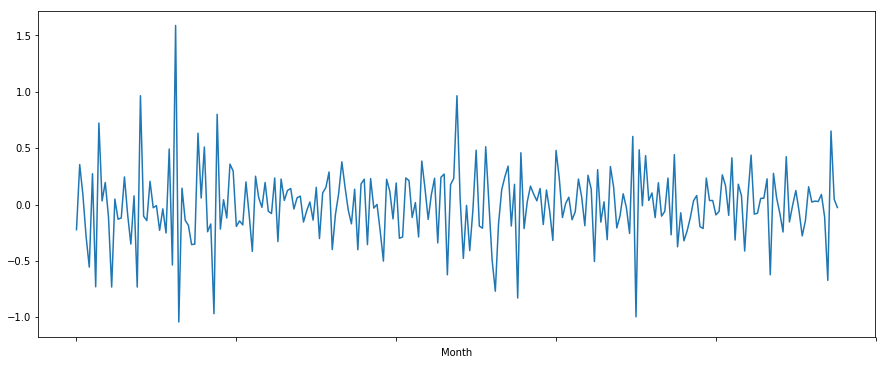

In [281]:
diff_sdiff_ts_wage_boxcox_all = (sdiff_ts_wage_boxcox_all - sdiff_ts_wage_boxcox_all .shift(1))[1:]
diff_sdiff_ts_wage_boxcox_all.plot(figsize=(15,6))

In [282]:
start = str(diff_sdiff_ts_wage_boxcox_all.index[0]).split(" ")[0] 
end = str(diff_sdiff_ts_wage_boxcox_all.index[diff_sdiff_ts_wage_boxcox_all.size-1]).split(" ")[0]

C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


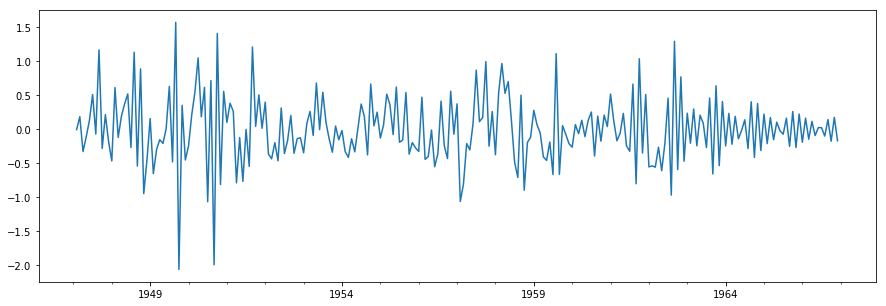

In [283]:
fig, ax = plt.subplots(figsize=(15,5),  linewidth=3.0)
fig = arima_mod_11_1_1.predict(start=start, end=end).plot()
# legend = ax.legend(loc='upper left')

C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


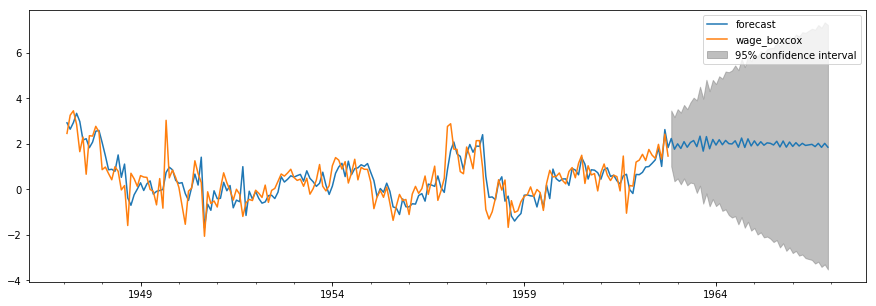

In [285]:
fig, ax = plt.subplots(figsize=(15,5),  linewidth=3.0)
fig = arima_mod_11_1_1.plot_predict(start=start, end=end, ax=ax)
# legend = ax.legend(loc='upper left')

* 9) build forecast interval for the last 20% of the transformed initial TS. Calculate loss MACAPE of your forecast. Does the forecast look appropriate?

Text(0.5,1,'Истинные значения 20% тестовых данных')

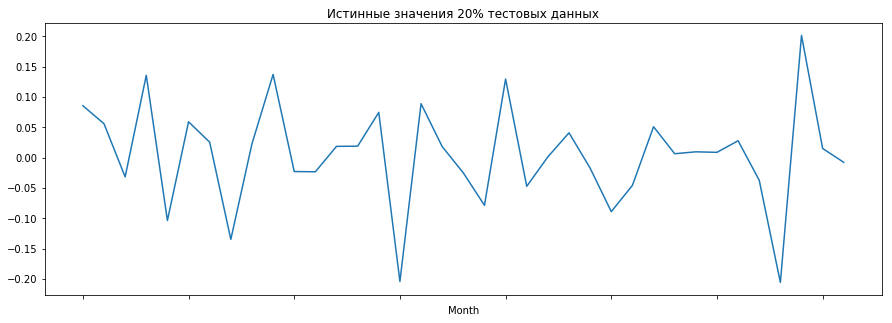

In [336]:
# Put your code here
ts_wage_test = ts_wage_test.astype(float)
ts_wage_test = deepcopy(ts_wage_test)
ts_wage_boxcox_test['wage_boxcox_test'] = np.log(ts_wage_test)
p = 12
sdiff_ts_wage_boxcox_test = (ts_wage_boxcox_test['wage_boxcox_test'] - ts_wage_boxcox_test['wage_boxcox_test'].shift(p))[p:]
#sdiff_ts_wage_boxcox_test.plot(figsize=(15,6))
diff_sdiff_ts_wage_boxcox_test = (sdiff_ts_wage_boxcox_test - sdiff_ts_wage_boxcox_test.shift(1))[1:]
diff_sdiff_ts_wage_boxcox_test.plot(figsize=(15,5))
plt.title('Истинные значения 20% тестовых данных')

C:\Users\Nadezhda\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Text(0.5,1,'Предсказания')

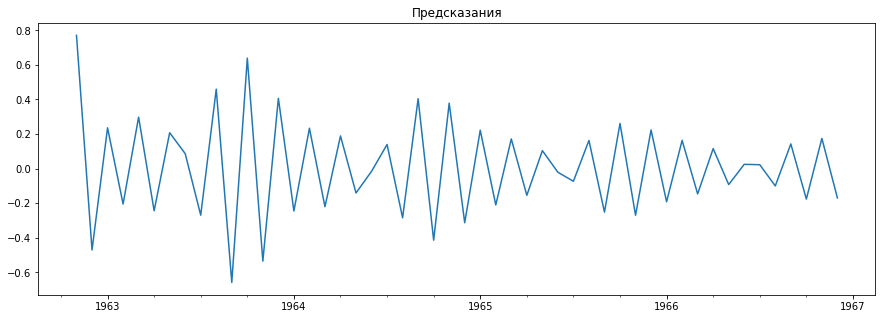

In [332]:
fig, ax = plt.subplots(figsize=(15,5),  linewidth=3.0)
fig = arima_mod_11_1_1.predict(start='1962-11', end='1966-12').plot()
plt.title('Предсказания')
# legend = ax.legend(loc='upper left')

<h1 align="center">Практическая часть II (50%)</h1> 
Мы будем решать достаточно классическую задачу классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

In [2]:
import os

In [3]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

In [4]:
y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

In [5]:
legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

In [6]:
from sklearn.decomposition import PCA
pca = PCA()

In [7]:
X_train_pca = pca.fit_transform(X_train_with_engineered_features)

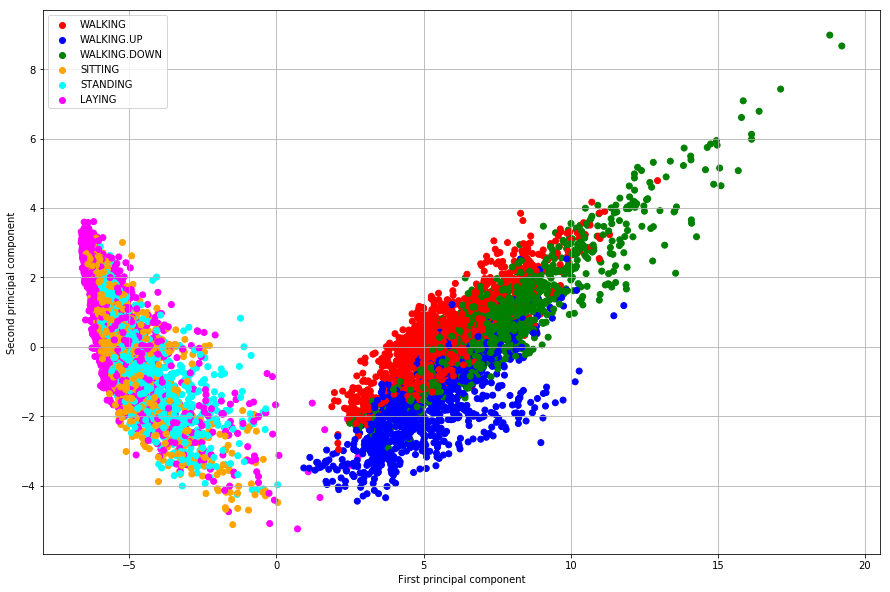

In [8]:
plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

### Часть 0. Разогрев. 
Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

### Часть 1. Предобработка данных.
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition).

In [9]:
import os

In [10]:
os.path.join('data', 'etc', 'file1.asdas')

'data\\etc\\file1.asdas'

In [11]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [12]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


### Часть 2. Построение сети и эксперименты. (50% +)
Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 80%. Это может оказаться нетривиальной задачей, поэтому трезво оценивайте свои силы. 

__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи задача была решена благодаря ..."

Базовая модель построена с использованием библиотеки `keras` для вас. Вы можете использовать любой знакомый вам фреймворк. Удачи в экспериментах. 

__Bonus__: при достижении 85% accuracy - 25% бонусных баллов, при достижении 89% accuracy - 50% бонусных баллов (т.е. ещё 25%).

In [13]:
import keras

C:\Users\Nadezhda\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout, SimpleRNN, Embedding, Reshape, BatchNormalization
from keras.utils import to_categorical
from keras import regularizers

from sklearn.metrics import accuracy_score

In [15]:
#Create model
# Можно не запускать
model = Sequential()
model.add(LSTM(units=196, activation='relu',
               input_shape=(128, 9)))    # the batch size is neglected!
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

Метки классов стоит перевести в one-hot-encoded формат (теперь это векторы вероятностей принадлежности классу). 

In [16]:
def one_hot_encode(y, n_classes):
    # y - [n_samples, 1] - class labels
    # n_classes - int - number of unique class labels
    #
    # return:
    # one_hot_encoded_y - [n_samples, n_classes] of type float - probabilities of 
    #                                                            class-accordance (target class has 1., other - 0.)
    return keras.utils.to_categorical(y, num_classes=n_classes)
    #n_labels = len(y)
    #one_hot_encode = np.zeros((n_labels,n_classes))
    #one_hot_encode[np.arange(n_labels), y] = 1
    #return one_hot_encode
    

In [17]:
y_train_one_hot = one_hot_encode(y_train, 10)
y_test_one_hot = one_hot_encode(y_test, 10)

In [27]:
#Можно не запускать. Часть эксперимента.
model.fit(X_train, y_train_one_hot, batch_size=128, epochs=40)

Epoch 1/40
7352/7352 [==============================] - 35s 5ms/step - loss: 2.1463 - acc: 0.4871
Epoch 2/40
7352/7352 [==============================] - 35s 5ms/step - loss: 1.8077 - acc: 0.5778
Epoch 3/40
7352/7352 [==============================] - 34s 5ms/step - loss: 1.5665 - acc: 0.5785
Epoch 4/40
7352/7352 [==============================] - 33s 4ms/step - loss: 1.5344 - acc: 0.5185
Epoch 5/40
7352/7352 [==============================] - 33s 4ms/step - loss: 1.5495 - acc: 0.4536
Epoch 6/40
7352/7352 [==============================] - 33s 4ms/step - loss: 1.7501 - acc: 0.5188
Epoch 7/40
7352/7352 [==============================] - 35s 5ms/step - loss: 1.9224 - acc: 0.4946
Epoch 8/40
7352/7352 [==============================] - 34s 5ms/step - loss: 1.7274 - acc: 0.4202
Epoch 9/40
7352/7352 [==============================] - 36s 5ms/step - loss: 1.3295 - acc: 0.5415
Epoch 10/40
7352/7352 [==============================] - 37s 5ms/step - loss: nan - acc: 0.4841
Epoch 11/40
7352/7352 

KeyboardInterrupt: 

In [93]:
accuracy_score(y_test, model.predict_classes(X_test))

0.4448591788259247

In [99]:
#Create model
#Пронумерум для дальнейшего удобства
#MODEL 1
model = Sequential()
model.add(LSTM(128, activation='relu',
               input_shape=(128, 9)))    # the batch size is neglected!
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train, y_train_one_hot, batch_size=128, epochs=40)

accuracy_score(y_test, model.predict_classes(X_test))

Epoch 1/40
7352/7352 [==============================] - 53s 7ms/step - loss: 2.1705 - acc: 0.4202
Epoch 2/40
7352/7352 [==============================] - 40s 5ms/step - loss: 1.8608 - acc: 0.4219
Epoch 3/40
7352/7352 [==============================] - 40s 5ms/step - loss: 3.5750 - acc: 0.3881
Epoch 4/40
7352/7352 [==============================] - 40s 5ms/step - loss: 1.8061 - acc: 0.5027
Epoch 5/40
7352/7352 [==============================] - 40s 5ms/step - loss: 5.7741 - acc: 0.4275
Epoch 6/40
7352/7352 [==============================] - 41s 6ms/step - loss: 11.9094 - acc: 0.2612
Epoch 7/40
7352/7352 [==============================] - 40s 5ms/step - loss: 11.4747 - acc: 0.2881
Epoch 8/40
7352/7352 [==============================] - 41s 6ms/step - loss: 11.4572 - acc: 0.2892
Epoch 9/40
7352/7352 [==============================] - 41s 6ms/step - loss: 11.4572 - acc: 0.2892
Epoch 10/40
7352/7352 [==============================] - 41s 6ms/step - loss: 11.4572 - acc: 0.2892
Epoch 11/40
73

KeyboardInterrupt: 

In [105]:
#Create model
#MODEL 2
model = Sequential()
model.add(LSTM(128, activation='relu',
               input_shape=(128, 9)))    # the batch size is neglected!
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

y_train_one_hot = one_hot_encode(y_train, 6)
y_test_one_hot = one_hot_encode(y_test, 6)

model.fit(X_train, y_train_one_hot, batch_size=128, epochs=10)

accuracy_score(y_test, model.predict_classes(X_test))

Epoch 1/10
7352/7352 [==============================] - 106s 14ms/step - loss: 1.7188 - acc: 0.4422
Epoch 2/10
7352/7352 [==============================] - 91s 12ms/step - loss: 1.5396 - acc: 0.5218
Epoch 3/10
7352/7352 [==============================] - 52s 7ms/step - loss: 1.8941 - acc: 0.5279
Epoch 4/10
7352/7352 [==============================] - 61s 8ms/step - loss: 1.3309 - acc: 0.5993
Epoch 5/10
7352/7352 [==============================] - 66s 9ms/step - loss: 1.6309 - acc: 0.6557
Epoch 6/10
7352/7352 [==============================] - 70s 9ms/step - loss: 1.6516 - acc: 0.3285
Epoch 7/10
7352/7352 [==============================] - 58s 8ms/step - loss: 1.3430 - acc: 0.5891
Epoch 8/10
7352/7352 [==============================] - 72s 10ms/step - loss: 1.3808 - acc: 0.6238
Epoch 9/10
7352/7352 [==============================] - 62s 8ms/step - loss: 2.1643 - acc: 0.5891
Epoch 10/10
7352/7352 [==============================] - 76s 10ms/step - loss: 0.9526 - acc: 0.6443


0.5765184933831015

In [107]:
#Create model
#MODEL 3
model = Sequential()
model.add(LSTM(196, activation='relu',
               input_shape=(128, 9)))    # the batch size is neglected!
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

y_train_one_hot = one_hot_encode(y_train, 6)
y_test_one_hot = one_hot_encode(y_test, 6)

model.fit(X_train, y_train_one_hot, batch_size=128, epochs=10)

accuracy_score(y_test, model.predict_classes(X_test))

Epoch 1/10
7352/7352 [==============================] - 93s 13ms/step - loss: 2.1548 - acc: 0.5012
Epoch 2/10
7352/7352 [==============================] - 86s 12ms/step - loss: 2.0877 - acc: 0.3950
Epoch 3/10
7352/7352 [==============================] - 114s 15ms/step - loss: 2.0268 - acc: 0.6055
Epoch 4/10
7352/7352 [==============================] - 153s 21ms/step - loss: 2.4352 - acc: 0.5292
Epoch 5/10
7352/7352 [==============================] - 152s 21ms/step - loss: 2.2396 - acc: 0.4736
Epoch 6/10
7352/7352 [==============================] - 155s 21ms/step - loss: 1.2449 - acc: 0.6268
Epoch 7/10
7352/7352 [==============================] - 138s 19ms/step - loss: 1.5059 - acc: 0.6779
Epoch 8/10
7352/7352 [==============================] - 133s 18ms/step - loss: 1.4035 - acc: 0.5905
Epoch 9/10
7352/7352 [==============================] - 128s 17ms/step - loss: 1.1497 - acc: 0.6246
Epoch 10/10
7352/7352 [==============================] - 151s 21ms/step - loss: 0.9468 - acc: 0.6590


0.6189345096708517

In [115]:
#Create model
#MODEL 4
model = Sequential()
model.add(LSTM(196, activation='relu',
               input_shape=(128, 9)))    # the batch size is neglected!
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

y_train_one_hot = one_hot_encode(y_train, 6)
y_test_one_hot = one_hot_encode(y_test, 6)

model.fit(X_train, y_train_one_hot, batch_size=128, epochs=17)
accuracy_score(y_test, model.predict_classes(X_test))

Epoch 1/17
7352/7352 [==============================] - 142s 19ms/step - loss: 1.8537 - acc: 0.5220
Epoch 2/17
7352/7352 [==============================] - 117s 16ms/step - loss: 2.7408 - acc: 0.4977
Epoch 3/17
7352/7352 [==============================] - 116s 16ms/step - loss: 1.9751 - acc: 0.5494
Epoch 4/17
7352/7352 [==============================] - 117s 16ms/step - loss: 1.3612 - acc: 0.5188
Epoch 5/17
7352/7352 [==============================] - 116s 16ms/step - loss: 1.3227 - acc: 0.5774
Epoch 6/17
7352/7352 [==============================] - 116s 16ms/step - loss: 1.4583 - acc: 0.6378
Epoch 7/17
7352/7352 [==============================] - 116s 16ms/step - loss: 2.2261 - acc: 0.6162
Epoch 8/17
7352/7352 [==============================] - 116s 16ms/step - loss: 1.3220 - acc: 0.5656
Epoch 9/17
7352/7352 [==============================] - 116s 16ms/step - loss: 1.0710 - acc: 0.6454
Epoch 10/17
7352/7352 [==============================] - 116s 16ms/step - loss: 1.0390 - acc: 0.6680

0.168306752629793

In [24]:
#Create model
#MODEL 5
model = Sequential()
model.add(LSTM(16, activation='relu',
               input_shape=(128, 9)))    # the batch size is neglected!
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(9, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

y_train_one_hot = one_hot_encode(y_train, 9)
y_test_one_hot = one_hot_encode(y_test, 9)

model.fit(X_train, y_train_one_hot, batch_size=128, epochs=40)

accuracy_score(y_test, model.predict_classes(X_test))

Epoch 1/40
7352/7352 [==============================] - 15s 2ms/step - loss: 1.8740 - acc: 0.4278
Epoch 2/40
7352/7352 [==============================] - 4s 604us/step - loss: 1.0881 - acc: 0.6540
Epoch 3/40
7352/7352 [==============================] - 4s 609us/step - loss: 0.8272 - acc: 0.7212
Epoch 4/40
7352/7352 [==============================] - 5s 616us/step - loss: 0.6763 - acc: 0.7670
Epoch 5/40
7352/7352 [==============================] - 4s 612us/step - loss: 0.5730 - acc: 0.7991
Epoch 6/40
7352/7352 [==============================] - 4s 611us/step - loss: 0.4956 - acc: 0.8267
Epoch 7/40
7352/7352 [==============================] - 4s 602us/step - loss: 0.4275 - acc: 0.8497
Epoch 8/40
7352/7352 [==============================] - 4s 603us/step - loss: 0.3650 - acc: 0.8799
Epoch 9/40
7352/7352 [==============================] - 5s 615us/step - loss: 0.2911 - acc: 0.9014
Epoch 10/40
7352/7352 [==============================] - 4s 595us/step - loss: 0.3057 - acc: 0.8945
Epoch 11/4

0.8907363420427553

In [25]:
#Create model
#MODEL 6
model = Sequential()
model.add(LSTM(16, activation='relu',
               input_shape=(128, 9)))    # the batch size is neglected!
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
#model.add(Dense(9, activation='softmax'))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(9, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

y_train_one_hot = one_hot_encode(y_train, 9)
y_test_one_hot = one_hot_encode(y_test, 9)

model.fit(X_train, y_train_one_hot, batch_size=128, epochs=40)
accuracy_score(y_test, model.predict_classes(X_test))

Epoch 1/40
7352/7352 [==============================] - 15s 2ms/step - loss: 1.4500 - acc: 0.5381
Epoch 2/40
7352/7352 [==============================] - 4s 574us/step - loss: 0.8828 - acc: 0.6853
Epoch 3/40
7352/7352 [==============================] - 4s 573us/step - loss: 0.6831 - acc: 0.7481
Epoch 4/40
7352/7352 [==============================] - 4s 567us/step - loss: 0.5770 - acc: 0.7841
Epoch 5/40
7352/7352 [==============================] - 4s 572us/step - loss: 0.4991 - acc: 0.8094
Epoch 6/40
7352/7352 [==============================] - 4s 570us/step - loss: 0.4374 - acc: 0.8338
Epoch 7/40
7352/7352 [==============================] - 4s 572us/step - loss: 0.3809 - acc: 0.8584
Epoch 8/40
7352/7352 [==============================] - 4s 561us/step - loss: 0.3322 - acc: 0.8784
Epoch 9/40
7352/7352 [==============================] - 4s 572us/step - loss: 0.2902 - acc: 0.8959
Epoch 10/40
7352/7352 [==============================] - 4s 568us/step - loss: 0.2607 - acc: 0.9027
Epoch 11/4

In [26]:
accuracy_score(y_test, model.predict_classes(X_test))

0.8832711231761113

In [18]:
#Create model
#MODEL 7
model = Sequential()
model.add(LSTM(50, activation='relu',
               input_shape=(128, 9)))    # the batch size is neglected!
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
#model.add(Dense(9, activation='softmax'))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(9, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

y_train_one_hot = one_hot_encode(y_train, 9)
y_test_one_hot = one_hot_encode(y_test, 9)

model.fit(X_train, y_train_one_hot, batch_size=128, epochs=40)
accuracy_score(y_test, model.predict_classes(X_test))

Epoch 1/40
7352/7352 [==============================] - 17s 2ms/step - loss: 1.3232 - acc: 0.6172
Epoch 2/40
7352/7352 [==============================] - 9s 1ms/step - loss: 0.7298 - acc: 0.7933
Epoch 3/40
7352/7352 [==============================] - 8s 1ms/step - loss: 0.5002 - acc: 0.8501
Epoch 4/40
7352/7352 [==============================] - 8s 1ms/step - loss: 0.3893 - acc: 0.8785
Epoch 5/40
7352/7352 [==============================] - 8s 1ms/step - loss: 0.3068 - acc: 0.9004
Epoch 6/40
7352/7352 [==============================] - 8s 1ms/step - loss: 0.2574 - acc: 0.9150
Epoch 7/40
7352/7352 [==============================] - 8s 1ms/step - loss: 0.2610 - acc: 0.9108
Epoch 8/40
7352/7352 [==============================] - 8s 1ms/step - loss: 0.2119 - acc: 0.9246
Epoch 9/40
7352/7352 [==============================] - 8s 1ms/step - loss: 0.1844 - acc: 0.9354
Epoch 10/40
7352/7352 [==============================] - 9s 1ms/step - loss: 0.1660 - acc: 0.9385
Epoch 11/40
7352/7352 [=====

0.8873430607397353

В общем, лучший скор в чистые 89% показала MODEL 5